In [1]:
from Bio.SearchIO import HmmerIO
from Bio import AlignIO, SeqIO
from Bio.AlignIO import StockholmIO
import re 

import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import numpy as np

from glob import glob
from joblib import Parallel, delayed
import os

from tqdm.notebook import tqdm

import pandas as pd
from addict import Dict

import pfam
import random
import seaborn as sns
from matplotlib_venn import venn2, venn3, venn3_unweighted, venn2_unweighted

from hmm_search_funcs import *

pd.options.display.max_columns = 80

In [2]:
# ! mkdir temp

# Start info

In [2]:
INCLUDE = ['PF03598', 'PF19436']
EXCLUDE = ['PF00374', 'PF00346', 'PF03116']

FAMILIES = Dict()
FAMILIES.default['PF03598'].name = 'acetylCoA-synthase'
FAMILIES.default['PF19436'].name = 'ACS_CODH_B_C'
FAMILIES.default['PF00374'].name = 'Ech-hydrogenase_NiFeSe_Hases'
FAMILIES.default['PF00346'].name = 'Ech-hydrogenase_Complex1_49kDa'
FAMILIES.default['PF03116'].name = 'RnfD'

# Load pathes and taxonomy

In [3]:
taxonomy_args = {'sep': '\\t|;', 'header': None, 'names' :  ['accession', 'd','p', 'c', 'o', 'f', 'g', 's'],
                'index_col' : None, 'engine': 'python'}

TAXONOMY = pd.concat([pd.read_csv('../gtdb_info/bac120_taxonomy_r202.tsv', **taxonomy_args),
                      pd.read_csv('../gtdb_info/ar122_taxonomy_r202.tsv', **taxonomy_args)])
TAXONOMY['species'] = TAXONOMY.s.apply(lambda x: x[3:])

# METADATA = pd.concat([pd.read_csv('../gtdb_info/bac120_metadata_r202.tsv', sep ='\t'),
#                       pd.read_csv('../gtdb_info/ar122_metadata_r202.tsv', sep ='\t')])

# meta_cols = [ 'ncbi_molecule_count',  'ncbi_organism_name', 'ncbi_refseq_category', 
#           'ncbi_species_taxid',  'ncbi_strain_identifiers', 'ncbi_submitter', 'ncbi_taxid', 
#           'ncbi_taxonomy', 'ncbi_taxonomy_unfiltered', 
#          ]


pheno = pd.read_csv('../phenotraits/condensed_species_GTDB.csv')
pheno_cols = ['species_tax_id', 'gram_stain', 'metabolism', 'pathways', 
'isolation_source', 'genome_size', 'growth_tmp', 'data_source']

In [5]:
# TAXONOMY.to_csv('../gtdb_info/gtdb_taxonomy.csv', index = False)

In [4]:
import pandas as pd
from glob import glob 
pathes = pd.DataFrame(
    glob('/media/pc208/es/litvinanna/gtdb-202/genomic_files_reps/protein_faa_reps/*/*'), 
    columns = ['path'])

pathes['accession'] = pathes.path.apply(lambda x: x.split('/')[-1][:18])
pathes['assembly']  = pathes.path.apply(lambda x: x.split('/')[-1][3:18])
pathes['kindom']    = pathes.path.apply(lambda x: x.split('/')[-2])
pathes = pathes.merge(TAXONOMY[['accession', 'species']])

In [7]:
# pathes.to_csv('../gtdb_info/pathes.csv', index = False)

# [optional] Load PFAM models and search

In [ ]:
# Collect info about selected pfam families
# takes a while? (why?)
# pip install ../python-pfam
for pfam_id in INCLUDE + EXCLUDE:
    family = pfam.family(pfam_id) # load family
    FAMILIES[pfam_id].cutoff = family.hmm_details.cutoffs['trusted'].sequence # get cutoff
    print(pfam_id, FAMILIES[pfam_id].cutoff)

In [ ]:
# test pfam object
family = pfam.family('PF19436')
for k, v in family.hmm_details.cutoffs.items():
    print(f'{k:>10} {v.domain:>10} {v.sequence:>10}')

In [ ]:
# load HMM models
[load_pfam(pfam_id) for pfam_id in INCLUDE + EXCLUDE]

In [ ]:
for pfam in INCLUDE + EXCLUDE:
    for i in tqdm(
        glob('/media/pc208/es/litvinanna/gtdb-202/genomic_files_reps/protein_faa_reps/bacteria/*'), 
        total = 45500, ncols = 100
    ):
            run_hmmsearch(i, pfam, outdir = 'hmmsearch_results')

In [ ]:
for pfam in INCLUDE + EXCLUDE:
    for i in tqdm(
        glob('/media/pc208/es/litvinanna/gtdb-202/genomic_files_reps/protein_faa_reps/archaea/*'), 
        total = 2339, ncols = 100
    ):
            run_hmmsearch(i, pfam, 'hmmsearch_results')

## Update Families info

In [5]:
# from loaded data
FAMILIES.default.update(Dict(
    
{'PF03598': {'cutoff': 21.3, 'cutoff_name' : 'bitscore'},
 'PF19436': {'cutoff': 26.8, 'cutoff_name' : 'bitscore'},
 'PF00374': {'cutoff': 25.8, 'cutoff_name' : 'bitscore'},
 'PF00346': {'cutoff': 24.0, 'cutoff_name' : 'bitscore'},
 'PF03116': {'cutoff': 27.7, 'cutoff_name' : 'bitscore'},
 'PF00374andPF00346': {'cutoff': 0.5, 'cutoff_name' : 'PF00374andPF00346'},
 'PF03598andPF19436': {'cutoff': 0.5, 'cutoff_name' : 'PF03598andPF19436'},
}
))

# Read search results

In [6]:
# Read hmmsearch findings
for pfam_id in INCLUDE + EXCLUDE:
    FAMILIES.default[pfam_id].df = parse_hmmresults(f'hmmsearch_results/{pfam_id}/*')
for hmm_name in INCLUDE + EXCLUDE:
    FAMILIES.default[hmm_name].df = FAMILIES.default[hmm_name].df\
        .merge(pathes, left_on = 'genome', right_on = 'accession')
    
    FAMILIES.default[hmm_name].df['description'] = FAMILIES.default[hmm_name].df\
        .apply(lambda x: f'{x.bitscore} {x.kindom} {x.species}', axis = 1)   

100%|███████████████████████████████████████████████████████| 47894/47894 [00:15<00:00, 3185.14it/s]


## [optional] draw bitscore distribution

In [7]:
INCLUDE + EXCLUDE

['PF03598', 'PF19436', 'PF00374', 'PF00346', 'PF03116']

In [10]:
FAMILIES.default.PF03598.name

'acetylCoA-synthase'

In [48]:
# # Plot findings bitscore distribution
# _, ax = plt.subplots(2, 3, figsize = (15, 7))
# for pfam_id, axis in zip(INCLUDE + EXCLUDE, ax.flatten()):
#     try:
#         plot_hmm_results(FAMILIES.default[pfam_id].df, FAMILIES.default[pfam_id].cutoff, 
#                          FAMILIES.default[pfam_id].name, axis)
#         axis.set_title(FAMILIES.default[pfam_id].name)
# #         axis.set_yscale('log')
#     except Exception as e:
#         pass

In [99]:
FAMILIES.default.keys()

dict_keys(['PF03598', 'PF19436', 'PF00374', 'PF00346', 'PF03116', 'PF00374andPF00346', 'PF03598andPF19436'])

## Filter findings

In [13]:
def merge_inplace(parent, attribute, df2, left_on = None, right_on = None, left_index = False, right_index = False):
    parent[attribute] = parent[attribute].merge(df2,  left_on = left_on, right_on = right_on, left_index = left_index, right_index = right_index)

In [14]:
combine_domains(FAMILIES.default, FAMILIES.default, ['PF00374', 'PF00346'])
merge_inplace(FAMILIES.default.PF00374andPF00346, 'df', pathes, left_on = 'genome', right_on = 'accession')

In [15]:
combine_domains(FAMILIES.default, FAMILIES.default, ['PF03598', 'PF19436'])
merge_inplace(FAMILIES.default.PF03598andPF19436, 'df', pathes, left_on = 'genome', right_on = 'accession')

In [16]:
filter_findings(FAMILIES.default, FAMILIES.default, INCLUDE+EXCLUDE+['PF00374andPF00346', 'PF03598andPF19436'])
# Логический отбор по наличию/отсутствию белков
# make_final(FAMILIES.default,  INCLUDE+EXCLUDE+['PF00374andPF00346'])
# logical_selection(FAMILIES.default, ['PF03598'], ['PF03116', 'PF00374andPF00346'])

PF03598 bitscore > 21.3
PF19436 bitscore > 26.8
PF00374 bitscore > 25.8
PF00346 bitscore > 24.0
PF03116 bitscore > 27.7
PF00374andPF00346 PF00374andPF00346 > 0.5
PF03598andPF19436 PF03598andPF19436 > 0.5


In [17]:
print_families(FAMILIES, INCLUDE+EXCLUDE +['PF00374andPF00346', 'PF03598andPF19436'])

,name,findings > cutoff
PF03598,acetylCoA-synthase,2805.0
PF19436,ACS_CODH_B_C,2519.0
PF00374,Ech-hydrogenase_NiFeSe_Hases,24587.0
PF00346,Ech-hydrogenase_Complex1_49kDa,43841.0
PF03116,RnfD,24818.0
PF00374andPF00346,{},6355.0
PF03598andPF19436,{},2334.0


In [106]:
for key in INCLUDE+EXCLUDE:
    print(key, FAMILIES.default[key].df_filt.shape)

PF03598 (2805, 20)
PF19436 (2519, 19)
PF00374 (24587, 19)
PF00346 (43841, 19)
PF03116 (24818, 21)


In [109]:
for key in INCLUDE+EXCLUDE + ['PF00374andPF00346', 'PF03598andPF19436']:
    print(key, FAMILIES.group2[key].df_filt.shape)

PF03598 (2331, 20)
PF19436 {}
PF00374 {}
PF00346 {}
PF03116 (24818, 21)
PF00374andPF00346 (4249, 16)
PF03598andPF19436 {}


In [18]:
# for file in sorted(list(glob('alignments/*PF*'))):
#     r = subprocess.run(f'grep ">" {file} | wc -l', shell = True, capture_output = True)
#     number = int(r.stdout.decode('utf-8').strip())
#     print(f'{file:<60}  {number}')

# PF03598 -- сделано

In [ ]:
# [optional] Записать выравнивание

hmm_name = 'PF03598'

#Создали файл со всеми находками PF03598 -- 
write_records(df = FAMILIES.default[hmm_name].df_filt,
            fasta_id    = 'fasta_id',
            path        = 'path',
            filename    =  f'alignments/{hmm_name}.fasta',
            description = 'description'
               )
# # Из файла с находками сделали модельку
# create_sample_hmm(f'alignments/{hmm_name}.fasta', f'hmms/{hmm_name}_50.hmm', sample = 50)

# Выровняли находки по созданной модельке
align_hmm(f'hmms/{hmm_name}_50.hmm', f'alignments/{hmm_name}.fasta', f'alignments/{hmm_name}.fasta')

In [ ]:
FAMILIES.default.PF03598.df_filt.shape[0]

In [49]:
# вспомнить новые скоры
hmm_name = 'PF03598'

# new_bitscore = rescore_sequences('hmmsearch_results/PF03598_50', f'alignments/{hmm_name}.fasta',  f'hmms/{hmm_name}_50.hmm')
new_bitscore = rescore_sequences(f'hmmsearch_results/{hmm_name}_50')
FAMILIES.default[hmm_name].df['new_bitscore'] = FAMILIES.default[hmm_name].df.fasta_id.map(new_bitscore)
# make_description(FAMILIES.default[hmm_name].df,['new_bitscore', 'kindom', 'species'], col = 'new_bitscore')

In [ ]:
# [optional] доделать выравнивание с новыми скорами
hmm_name = 'PF03598'
new_desc = dict(zip(FAMILIES.default[hmm_name].df.fasta_id, FAMILIES.default[hmm_name].df.description))
replace_description(f'alignments/{hmm_name}.fasta', new_desc, f'alignments/{hmm_name}_realigned.fasta')
sort_alignment(f'alignments/{hmm_name}_realigned.fasta', 1)

In [ ]:
# _, axs = plt.subplots(1, 2, figsize = (15, 4))
# FAMILIES.default.PF03598.df['bitscore'].plot.hist(bins = 1000, ax = axs[0], )
# axs[0].vlines(21.3, 0, 100, color = 'red')
# axs[0].set_title('PF03598 pfam bitscore')

# FAMILIES.default.PF03598.df['new_bitscore'].hist(bins = 1000, ax = axs[1])
# axs[1].vlines(250, 0, 40, color = 'red')
# axs[1].set_title('new bitscore')
# plt.show()

In [ ]:
#[optional] Создать выборочное выравнивание для 3 групп синтаз
df = FAMILIES.default.PF03598.df_filt
sample1 = df[(df.new_bitscore < 250)].sample(20)
sample2 = df[(df.new_bitscore > 550) & (df.new_bitscore < 750 )].sample(20)
sample3 = df[(df.new_bitscore > 1100) & (df.new_bitscore < 1250 )].sample(20)

write_records(df = pd.concat([sample1, sample2, sample3]),
            fasta_id    = 'fasta_id',
            path        = 'path',
            filename    =  f'alignments/PF03598_sample.fasta',
            description = 'description'
               )
subprocess.run('muscle -quiet -in alignments/PF03598_sample.fasta -out alignments/PF03598_sample.fasta', shell = True)
sort_alignment('alignments/PF03598_sample.fasta', 1)
subprocess.run('muscle -quiet -profile -in1 alignments/PF03598_sample.fasta -in2 hmms/PF03598_seed.fasta -out alignments/PF03598_sample.fasta', shell = True)

In [ ]:
df = FAMILIES.default.PF03598.df_filt
df = df.merge(TAXONOMY, left_on = 'genome', right_on = 'accession')
print( df[(df.new_bitscore < 250)]                            .d.value_counts())
print(df[(df.new_bitscore > 550) & (df.new_bitscore < 750 )]  .d.value_counts())
print(df[(df.new_bitscore > 1000) & (df.new_bitscore < 1300 )].d.value_counts())

# PF03598 and PF19436

<AxesSubplot:xlabel='PF03598_score', ylabel='PF19436_score'>

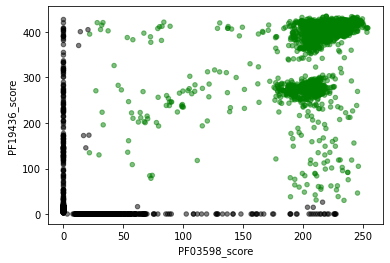

In [24]:
df = FAMILIES.default.PF03598andPF19436.df
df.fillna(0, inplace = True)
df.plot.scatter('PF03598_score', 'PF19436_score', alpha = 0.5, c = df['PF03598andPF19436'].map(
                                 {0:'black', 1 : 'green'}))

In [41]:
# [optional] Записать выравнивание

hmm_name = 'PF03598andPF19436'

#Создали файл со всеми находками  -- 
write_records(df = FAMILIES.default[hmm_name].df_filt,
            fasta_id    = 'fasta_id',
            path        = 'path',
            filename    =  f'alignments/{hmm_name}.fasta',
            description = None
               )
# Из файла с находками сделали модельку
create_sample_hmm(f'alignments/{hmm_name}.fasta', f'hmms/{hmm_name}_50.hmm', sample = 50, sample_alignment = f'hmms/{hmm_name}_50.hmm')
# Выровняли находки по созданной модельке
align_hmm(f'hmms/{hmm_name}_50.hmm', f'alignments/{hmm_name}.fasta', f'alignments/{hmm_name}.fasta')

100%|███████████████████████████████████████████████████████████| 2075/2075 [01:57<00:00, 17.66it/s]
rm: cannot remove 'temp.fasta': No such file or directory


created hmm-model hmms/PF03598andPF19436_50.hmm


In [22]:
! ls hmmsearch_results

PF00346  PF00374andPF00346_50  PF03116_50  PF03598_50
PF00374  PF03116	       PF03598	   PF19436


In [25]:
new_bitscore = rescore_sequences(f'hmmsearch_results/PF03598_50', 
                                 in_file = 'alignments/PF03598andPF19436.fasta', 
                                 hmm_file = 'hmms/PF03598andPF19436_50.hmm')
df['new_bitscore'] = df.fasta_id.map(new_bitscore)

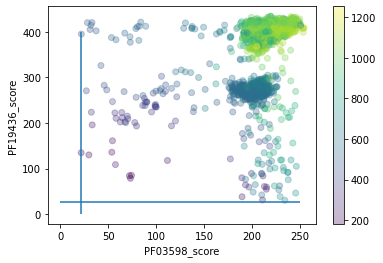

In [26]:
plt.scatter(df.PF03598_score, df.PF19436_score, alpha = 0.3,
                c = df['new_bitscore'])
plt.xlabel('PF03598_score'); plt.ylabel('PF19436_score')
plt.title('')
plt.vlines(21.3, 0, 400); plt.hlines(26.8, 0, 250)
plt.colorbar()

<AxesSubplot:>

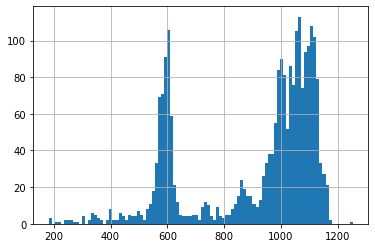

In [63]:
df.new_bitscore.hist(bins = 100)

In [59]:
make_description(FAMILIES.default[hmm_name].df, ['new_bitscore', 'kindom', 'species'], col = 'description')

In [60]:
# [optional] доделать выравнивание с новыми скорами
hmm_name = 'PF03598andPF19436'
new_desc = dict(zip(FAMILIES.default[hmm_name].df.fasta_id, FAMILIES.default[hmm_name].df.description))

replace_description(f'alignments/{hmm_name}.fasta', new_desc, f'alignments/{hmm_name}_realigned.fasta')
sort_alignment(f'alignments/{hmm_name}_realigned.fasta', 1)

# PF03116 RnfD

In [ ]:
# [optional] Записать выравнивание

hmm_name = 'PF03116'

#Создали файл со всеми находками  -- 
write_records(df = FAMILIES.default[hmm_name].df_filt,
            fasta_id    = 'fasta_id',
            path        = 'path',
            filename    =  f'alignments/{hmm_name}.fasta',
            description = 'description'
               )
# Из файла с находками сделали модельку
create_sample_hmm(f'alignments/{hmm_name}.fasta', f'hmms/{hmm_name}_50.hmm', sample = 50)
# Выровняли находки по созданной модельке
align_hmm(f'hmms/{hmm_name}_50.hmm', f'alignments/{hmm_name}.fasta', f'alignments/{hmm_name}.fasta')

In [27]:
# вспомнить новые скоры
hmm_name = 'PF03116'

# new_bitscore = rescore_sequences(f'hmmsearch_results/{hmm_name}_50', 
#                                  f'alignments/{hmm_name}.fasta',
#                                  f'hmms/{hmm_name}_50.hmm')
new_bitscore = rescore_sequences(f'hmmsearch_results/{hmm_name}_50')

FAMILIES.default[hmm_name].df['new_bitscore'] = FAMILIES.default[hmm_name].df.fasta_id.map(new_bitscore)
FAMILIES.default[hmm_name].df['description'] =  make_description(FAMILIES.default[hmm_name].df,
                                                                ['new_bitscore', 'kindom', 'species'])



In [ ]:
# [optional] доделать выравнивание с новыми скорами
hmm_name = 'PF03116'

new_desc = dict(zip(FAMILIES.default[hmm_name].df.fasta_id, FAMILIES.default[hmm_name].df.description))
replace_description(f'alignments/{hmm_name}.fasta', new_desc, f'alignments/{hmm_name}_realigned.fasta')
sort_alignment(f'alignments/{hmm_name}_realigned.fasta', 1)

In [ ]:
_, axs = plt.subplots(1, 2, figsize = (15, 4))
FAMILIES.default.PF03116.df['bitscore'].plot.hist(bins = 1000, ax = axs[0], )
axs[0].vlines(FAMILIES.default.PF03116.cutoff, 0, 100, color = 'red')
axs[0].set_title('PF03116 pfam bitscore')

FAMILIES.default.PF03116.df['new_bitscore'].hist(bins = 1000, ax = axs[1])
# axs[1].vlines(250, 0, 40, color = 'red')
axs[1].set_title('new bitscore')
plt.show()

In [28]:
# добавить новые колонки в df-filt
filter_findings(FAMILIES.default, FAMILIES.default, INCLUDE+EXCLUDE)

PF03598 bitscore > 21.3
PF19436 bitscore > 26.8
PF00374 bitscore > 25.8
PF00346 bitscore > 24.0
PF03116 bitscore > 27.7


In [ ]:
#[optional] выравнивание выборочное для иллюстрации
df = FAMILIES.default.PF03116.df_filt
sample1 = df[(df.new_bitscore > 60) & (df.new_bitscore < 85 )].sample(20)
sample2 = df[(df.new_bitscore) > 350 & (df.new_bitscore < 430 )].sample(20)

write_records(df = pd.concat([sample1, sample2]),
            fasta_id    = 'fasta_id',
            path        = 'path',
            filename    =  f'alignments/PF03116_sample.fasta',
            description = 'description'
               )
subprocess.run('muscle -quiet -in alignments/PF03116_sample.fasta -out alignments/PF03116_sample.fasta', shell = True)
sort_alignment('alignments/PF03116_sample.fasta', 1)
# subprocess.run('muscle  -quiet  -profile -in1 alignments/PF03116_sample.fasta  -in2 hmms/PF03116_seed.fasta -out alignments/PF03116_sample.fasta', shell = True)


# PF00374andPF00346

In [ ]:
# sample_alignment('hmms/PF03116_seed.fasta', 'hmms/PF03116_seed_20.fasta', n = 20)

In [ ]:
# [optional] Распределение находок в 2d
initial = FAMILIES.default.PF00374andPF00346.df.dropna(subset = ['PF00374_score', 'PF00346_score'])
initial.plot.scatter('PF00346_score','PF00374_score',alpha = 0.01, 
                             c = (initial['PF00374andPF00346']*initial['motifs']).map(
                                 {0:'black', 1 : 'green', -1: 'orange'})
                    )
plt.ylim(0, 150);plt.xlim(0, 600)
plt.show()

In [ ]:
# [optional] Распределение находок в 2d
initial = FAMILIES.default.PF00374andPF00346.df.dropna(subset = ['PF00374_score', 'PF00346_score'])
initial.plot.scatter('PF00346_score','PF00374_score',alpha = .1, 
                             c = initial['new_bitscore_motifs'], cmap = 'viridis')
plt.ylim(0, 150); plt.xlim(0, 600)
plt.show()

In [ ]:
make_description(FAMILIES.default.PF00374andPF00346.df, ['kindom', 'species'], col = 'description')

In [ ]:
filter_findings(FAMILIES.default, FAMILIES.default, ['PF00374andPF00346'])

In [ ]:
# [optional] записать все находки
hmm_name = 'PF00374andPF00346'
write_records(df = FAMILIES.default.PF00374andPF00346.df_filt,
            fasta_id    = 'fasta_id',
            path        = 'path',
            filename    =  f'alignments/{hmm_name}.fasta',
            description = 'description'
               )
hmm_name = 'PF00374andPF00346'
# # Из файла с находками сделали модельку
# create_sample_hmm(f'alignments/{hmm_name}.fasta', f'hmms/{hmm_name}_50.hmm', sample = 50)

# Выровняли находки по созданной модельке
align_hmm(f'hmms/{hmm_name}_50.hmm', f'alignments/{hmm_name}.fasta', f'alignments/{hmm_name}.fasta')

In [29]:
# прочитать новые скоры
hmm_name = 'PF00374andPF00346'

# new_bitscore = rescore_sequences(f'hmmsearch_results/{hmm_name}_50', 
#                                  f'alignments/{hmm_name}.fasta',
#                                  f'hmms/{hmm_name}_50.hmm')
new_bitscore = rescore_sequences(f'hmmsearch_results/{hmm_name}_50')

FAMILIES.default[hmm_name].df['new_bitscore'] = FAMILIES.default[hmm_name].df.fasta_id.map(new_bitscore)
make_description(FAMILIES.default[hmm_name].df, ['new_bitscore', 'kindom', 'species'], 'description')


In [ ]:
new_desc = dict(zip(FAMILIES.default[hmm_name].df.fasta_id, FAMILIES.default[hmm_name].df.description))
replace_description(f'alignments/{hmm_name}.fasta', new_desc, f'alignments/{hmm_name}_realigned.fasta')
sort_alignment(f'alignments/{hmm_name}_realigned.fasta', 1)

## Motifs

In [30]:
import regex
def find_CC(a):
    data = pd.DataFrame()
    for seq in a:
        i = seq.id
        data.at[i, 'start0'] = None
        for j, find in enumerate(regex.finditer('C-*[^-]-*[^-]-*C', str(seq.seq), overlapped=True)):
                data.at[i, f'start{j}'] = find.span()[0]
                data.at[i,   f'seq{j}'] = find.group()
    for seq in a:
        i = seq.id
        for j, find in enumerate(regex.finditer('C-*[^-]-*[^-]-*C', str(seq.seq), overlapped=True)):
                data.at[i,   f'{find.span()[0]}'] = find.group()
    return data


a = AlignIO.read('alignments/PF00374andPF00346.fasta', 'fasta')
data = find_CC(a)
print(data.shape)

# меняю порядок колонок вручную -- в поселдовательностях встречалось максимум три мотива
data = data[list(data.columns[:8]) + sorted(data.columns[8:], key = lambda x: int(x))]

(6355, 37)


In [31]:
# найти колонки с самыми частыми цистеиновыми мотивами
# data.notna().sum()

In [32]:
# это последовательности с двумя мотивами
data1 = data[data.start0.notna() & data.start1.notna()].copy()
print(data1.shape)

# последовательности с нужными мотивами, которые выровнялись
data2 = data[ data['739'].notna() & data['1714'].notna()].copy()
print(data2.shape)

(4252, 37)
(4249, 37)


In [33]:
# какие последовательности имеют два мотива, но не в тех места?

In [34]:
set(data1.index) - set(data2.index)

{'QMUJ01000021.1_1', 'RQOI01000160.1_1', 'USMA01000296.1_2'}

In [ ]:
# df = FAMILIES.default.PF00374andPF00346.df
# df = df[df.fasta_id.isin(data2.index)]
# write_records(df, 'fasta_id', 'path', 'alignments/PF00374andPF00346_motifs.fasta', 'description')
# align_hmm('hmms/PF00374andPF00346_50.hmm', 'alignments/PF00374andPF00346_motifs.fasta', 'alignments/PF00374andPF00346_motifs.fasta')
# sort_alignment('alignments/PF00374andPF00346_motifs.fasta', 1)

In [35]:
#Заассайнить данные про мотивы

FAMILIES.default.PF00374andPF00346.df.at[FAMILIES.default.PF00374andPF00346.df.fasta_id.isin(data2.index), 'motifs'] = 1
FAMILIES.default.PF00374andPF00346.df.motifs.fillna(-1, inplace = True)
FAMILIES.default.PF00374andPF00346.df['new_bitscore_motifs'] = FAMILIES.default.PF00374andPF00346.df.apply(lambda x: x.motifs * x.new_bitscore, axis = 1)
filter_findings(FAMILIES.default, FAMILIES.default, ['PF00374andPF00346'])

PF00374andPF00346 PF00374andPF00346 > 0.5


## Research with motifs information

In [78]:
# FAMILIES.default[hmm_name].df_filt.new_bitscore_motifs.hist(bins = 1000)
# plt.title(hmm_name + ' findings bitscore distribution')

In [ ]:
hmm_name = 'PF00374andPF00346'
df = FAMILIES.default[hmm_name].df_filt
sample = df[df.new_bitscore_motifs > 0].sample(20)
fn = f'alignments/{hmm_name}_sample.fasta'
write_records(df = sample,
            fasta_id    = 'fasta_id', path        = 'path',
            filename    =  fn,
            description = 'description'
               )
subprocess.run(f'muscle  -quiet -in {fn} -out {fn}', shell = True)
subprocess.run(f'muscle  -quiet -profile -in1 {fn}  -in2 hmms/PF00374_seed_20.fasta -out alignments/{hmm_name}_samplePF00374.fasta', shell = True)
subprocess.run(f'muscle  -quiet -profile -in1 {fn}  -in2 hmms/PF00346_seed_20.fasta -out alignments/{hmm_name}_samplePF00346.fasta', shell = True)


In [ ]:
! ls alignments

In [ ]:
initial = FAMILIES.default.PF00374andPF00346.df_filt.dropna(subset = ['PF00374_score', 'PF00346_score'])
initial = initial.merge(TAXONOMY, left_on = 'genome', right_on = 'accession')
initial.d.value_counts()

# Более жесткие отсечки

In [36]:
def make_final(group, keys):
    # В inct для каждого семейства я записала число находок в каждом геноме
    inct = Dict()
    for key in keys:
        inct[key] = group[key].df_filt.genome.value_counts()
        inct[key].name = key

    # Делаю датасет с числами вхождений всех семейств
    final_incl = pd.DataFrame()
    for key in keys:
        final_incl = final_incl.merge(inct[key], how = 'outer', left_index = True, right_index = True)
    final_incl.fillna(0, inplace = True)
    
    group.inclusion = final_incl
    return

In [51]:
FAMILIES.default.PF03116.df_filt.bitscore
FAMILIES.default.PF00374andPF00346.df_filt.new_bitscore_motifs
FAMILIES.default.PF03598.df.new_bitscore

0       1043.7
1          NaN
2          NaN
3          NaN
4       1090.6
         ...  
5004       NaN
5005    1097.2
5006    1058.6
5007    1040.0
5008       NaN
Name: new_bitscore, Length: 5009, dtype: float64

In [50]:
filter_findings(FAMILIES.default, FAMILIES.default, ['PF03598'])

PF03598 bitscore > 21.3


In [52]:
FAMILIES.group2.update(Dict(   
{
 'PF03598': {'cutoff': 200, 'cutoff_name' : 'new_bitscore'},
#  'PF00374': {'cutoff': 25.8, 'cutoff_name' : 'bitscore'},
#  'PF00346': {'cutoff': 24.0, 'cutoff_name' : 'bitscore'},
 'PF03116': {'cutoff': 27.7, 'cutoff_name' : 'bitscore'},
 'PF00374andPF00346': {'cutoff': 0, 'cutoff_name' : 'new_bitscore_motifs'},
#  'PF03598andPF19436': {'cutoff': 0, 'cutoff_name' : 'new_bitscore'},
}
))
# # Логический отбор по наличию/отсутствию белков
# Create cutoff filtered datasets
filter_findings(FAMILIES.group2, FAMILIES.default, ['PF03598','PF03116', 'PF00374andPF00346'])
# Логический отбор по наличию/отсутствию белков
make_final(FAMILIES.group2,  ['PF03598','PF03116', 'PF00374andPF00346', ])

logical_selection(FAMILIES.group2, ['PF03598'], ['PF03116', 'PF00374andPF00346'])

PF03598 new_bitscore > 200
PF03116 bitscore > 27.7
PF00374andPF00346 new_bitscore_motifs > 0


In [56]:
FAMILIES.group2.final_list.shape

(692, 3)

In [57]:
FAMILIES.group2.taxonomy = TAXONOMY[TAXONOMY.accession.isin(FAMILIES.group2.final_list.index)]
g2 = FAMILIES.group2.taxonomy

In [58]:
g2.d.value_counts()

d__Bacteria    485
d__Archaea     207
Name: d, dtype: int64

In [95]:
# g2[['d', 'p']].value_counts().sort_index()

# Microbiologists data

In [59]:
micro_data = pd.read_excel('info/ACS( )ECH(-)RnfD(-)RnfC(-).xlsx')
micro_data[micro_data['REQUIRED SET (1/0)'] == 1].iloc[0].SUBJECT

micro_data_yes = micro_data[micro_data['REQUIRED SET (1/0)'] == 1][['SUBJECT','REQUIRED SET (1/0)']].copy()
micro_data_yes['id']      = micro_data_yes.SUBJECT.apply(lambda x: x.split()[0][1:])
micro_data_yes['genus']   = micro_data_yes.SUBJECT.apply(lambda x: x.split()[1])
micro_data_yes['spesies'] = micro_data_yes.SUBJECT.apply(lambda x: x.split()[2])


micro_data_yes = micro_data_yes.merge(pd.read_csv('micro_data_yes'), how = 'left')
micro_data_yes = micro_data_yes.merge(pathes[['accession','assembly', 'species']], how = 'left')

In [60]:
micro_data_yes.shape

(28, 8)

In [61]:
# pd.options.display.max_columns = 150

In [62]:
# Desulfotomaculum kuznetsovii DSM 6115, complete genome
# Record removed. This record was removed by RefSeq staff. 
# Please contact info@ncbi.nlm.nih.gov for further details.

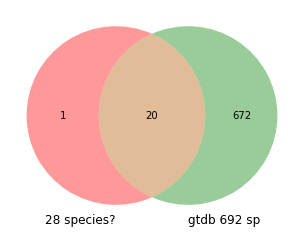

In [63]:
from matplotlib_venn import venn2_unweighted
venn2_unweighted([set(micro_data_yes.accession.dropna()),set(g2.accession)], 
                 set_labels = ['28 species?', f'gtdb {len(g2)} sp'])

In [ ]:
# micro_data_yes.accession.shape, micro_data_yes.accession.notna().sum()

In [ ]:
set(micro_data_yes.accession.dropna()) - set(g2.accession)

In [ ]:
TAXONOMY[TAXONOMY.accession.isin(['RS_GCF_000092205.1'])]

In [ ]:
FAMILIES.group2.inclusion\
.loc[['RS_GCF_000092205.1']]

In [ ]:
df = FAMILIES.default.PF03116.df
df = df[df.genome == 'RS_GCF_000092205.1']
write_records(df, fasta_id = 'fasta_id', path = 'path', filename = 'alignments/special_PF03116.fasta', 
              description='description')
subprocess.run('muscle -quiet -profile -in1 alignments/special_PF03116.fasta -in2 hmms/PF03116_seed_20.fasta -out alignments/special_PF03116.fasta', shell = True)


In [ ]:
df = FAMILIES.default.PF00374andPF00346.df_filt
df = df[df.genome.isin(four)]
fn = 'alignments/special_PF00374andPF00346.fasta'
write_records(df, fasta_id = 'fasta_id', path = 'path', filename = fn, 
              description='description')
subprocess.run(f'muscle -quiet -profile -in2 {fn} -in1 hmms/PF00374_seed_20.fasta -out {fn}', shell = True)
subprocess.run(f'muscle -quiet -profile -in1 {fn} -in2 hmms/PF00346_seed_20.fasta -out {fn}', shell = True)

In [ ]:
# filter_findings(FAMILIES.default, FAMILIES.default, ['PF00374andPF00346'])

In [65]:
g2 = g2.sort_values(['d', 'p', 'c', 'o', 'f', 's'])

In [111]:
g2.to_csv('groups/v1_taxonomy.tsv', index = False, sep = '\t')

In [110]:
g2.shape

(692, 9)

# Research phenotypes

In [70]:
pheno1 = pheno[pheno.species.isin(g2.species)][pheno_cols + ['species']].merge(g2)

In [71]:
pheno1.d.value_counts()

d__Bacteria    37
d__Archaea     35
Name: d, dtype: int64

array([<AxesSubplot:title={'center':'d__Archaea'}>,
       <AxesSubplot:title={'center':'d__Bacteria'}>], dtype=object)

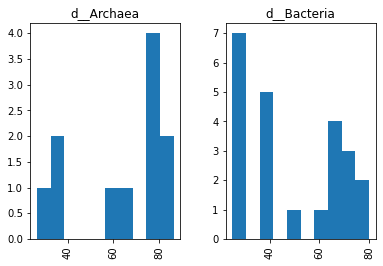

In [72]:
pheno1.hist('growth_tmp', by = 'd')

In [73]:
# pheno1.notna().sum()

In [74]:
pheno1.isolation_source.value_counts()

sediment_marine_hydrothermal    7
wastewater                      6
bioreactor/digester             3
water                           2
petroleum                       2
water_marine_hydrothermal       2
soil                            2
sediment_hypersaline            1
rock_deep                       1
sediment_marine                 1
water_fresh                     1
water_hotspring                 1
food_fermented                  1
volcanic_active                 1
soil_organic_permafrost         1
Name: isolation_source, dtype: int64

In [75]:
pheno1.pathways.notna().sum()

26

In [76]:
pheno1.metabolism.value_counts()

anaerobic             33
obligate anaerobic     3
Name: metabolism, dtype: int64

In [80]:
pheno1.dropna(subset = ['metabolism']).d.value_counts()

d__Bacteria    23
d__Archaea     13
Name: d, dtype: int64

In [91]:
pheno1.pathways.dropna().shape

(26,)

In [92]:
# pheno1.pathways.dropna().apply(lambda x: x.split(',')).explode().value_counts()

In [81]:
pheno1[['pathways', 'isolation_source', 'growth_tmp' , 'species', 'd', 'p']] \
.dropna(how = 'all', subset = ['pathways', 'isolation_source', 'growth_tmp' ])\
.sort_values(['d', 'p']).to_csv('groups/pheno.csv', index = False, sep = '\t')

In [112]:
# ! sed 's/,/\t/g' groups/711_taxonomy.csv >> groups/711_taxonomy.tsv 

In [109]:
# ! ls groups/711_taxonomy.csv 

In [113]:
# pheno1.to_csv('groups/v1_phenome.csv')